# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor


from imblearn.over_sampling import SMOTE, SMOTENC

from scipy.stats import ks_2samp
import warnings
import ast
import re

import umap
import xgboost
from xgboost import XGBClassifier


from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Flatten, Dropout
from keras.layers import Conv2DTranspose, Reshape
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD

from scipy import stats

/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500
warnings.filterwarnings('ignore')

In [3]:
# load in the data
azdias = pd.read_csv('data/azdias.csv')
customers = pd.read_csv('data/customers.csv')
azdias.drop('Unnamed: 0', axis=1, inplace=True)
customers.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
dias_attr = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=[0])
dias_attr.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
dias_info = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
dias_info.drop('Unnamed: 0', axis=1, inplace=True)
dias_info.replace({'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24':'D19_GESAMT_ANZ_12-24',
                  'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24':'D19_BANKEN_ ANZ_12-24',
                 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24':'D19_TELKO_ ANZ_12-24',
                 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24':'D19_VERSI_ ANZ_12-24',
                 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24':'D19_VERSAND_ ANZ_12-24'},inplace=True)

## Data Cleaning

#### Preliminary cleaning

In [6]:
def pre_clean(df):
    list_numeric = df.dtypes[(df.dtypes=='float64') | (df.dtypes=='int64') ].index.values.tolist()
    df[list_numeric] = df[list_numeric].astype('Int64')
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W':0, 'O':1}).astype("Int64")
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X':np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace({0:np.nan}).astype('Int64')
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace({0:np.nan}).astype('Int64')
    return df.drop('EINGEFUEGT_AM', axis=1)

In [7]:
azdias = pre_clean(azdias)

### Missing Data - convert missing value codes to NaNs


In [ ]:
def map_values(x, dict_missing):
    try:
        return dict_missing[x]
    except:
        return x
    
def missing_values(df):
    missing_df = dias_attr.query('Meaning=="unknown"')[['Attribute','Value']].dropna().set_index('Attribute')
    missing_df = missing_df['Value'].astype('str').str.split(',',expand=True).T
    missing_df = missing_df.applymap(lambda x: int(x) if x!=None else -100)

    for i in missing_df.columns.values:
        for j in [0,1]:
            dict_missing = {missing_df.loc[j,i]:np.nan}
            try:
                df[i] = df[i].map(lambda x: map_values(x, dict_missing)).astype('Int64')
            except:
                pass

    return df

In [ ]:
azdias = missing_values(azdias)

### Assess missing data per feature

Features with more than 445k entries missing were dropped

In [ ]:
feature_drop_list = pd.Series(azdias.isnull().sum()).where(lambda x:  x > 445E3).dropna().index.tolist()

In [ ]:
def drop_features(df, feature_drop_list):
    return df.drop(feature_drop_list, axis=1)

In [ ]:
azdias = drop_features(azdias, feature_drop_list)

## Data Imputation

In [ ]:
impute_estimator = KNeighborsRegressor(n_neighbors=5)
#impute_estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0)
def impute_numeric(df, strategy):
    imputer = IterativeImputer(random_state=0, estimator=impute_estimator, verbose=2)
    #imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    return imputer.fit(df)
    
def impute_object(df):
    #list_mode = df.apply(lambda x: x.mode()[0]).values.tolist()
    #list_columns = df.columns.values.tolist()
    #dict_mode = {i:j for i,j, in zip(list_columns, list_mode)}
    #return df.fillna(value=dict_mode)
    #imputer = IterativeImputer(random_state=0, estimator=impute_estimator, verbose=2)
    #imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    return imputer.fit(df)
    
def impute_calc(df):
    list_numeric = df.dtypes[(df.dtypes=='int64') | 
                             (df.dtypes=='Int64') | 
                             (df.dtypes=='float64')].index[1:].tolist()

    imputer_num = impute_numeric(df[list_numeric].astype('Int64'),'median')
    
    df[list_numeric] = imputer_num.transform(df[list_numeric].astype('Int64')).astype('int64')
    
    list_objects = df.dtypes[(df.dtypes=='object')].index.tolist()
    
    imputer_obj = impute_object(df[list_objects])
    
    df[list_objects] = imputer_obj.transform(df[list_objects])
    
    return df, imputer_num, imputer_obj, list_numeric, list_objects

def impute_tranform(df):
    df[list_numeric] = imputer_num.transform(df[list_numeric].astype('Int64')).astype('int64')
    df[list_objects] = imputer_obj.transform(df[list_objects])
    return df

In [ ]:
azdias2, imputer_num, imputer_obj, list_numeric, list_objects = impute_calc(azdias)

[IterativeImputer] Completing matrix with shape (891221, 351)


In [ ]:
azdias = azdias2.copy()

In [ ]:
azdias.isnull().values.any()

### Re-encode mixed features

After cleaning the data of all NaNs, the next step was to re-encode the variables with mixed fetures. The variables were:

* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015
* LP_LEBENSPHASE_FEIN
* LP_LEBENSPHASE_GROB

Variable  PLZ8_BAUMAX could also have been reencoded but the explanatory gains were not clear. The description of the new variables and their levels is presented on the notebook.

#### PRAEGENDE_JUGENDJAHRE

In [ ]:
def pragende_jugendjahre(df):
    pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df['PRAEGENDE_JUGENDJAHRE_intervall'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[int(x)])
    df['PRAEGENDE_JUGENDJAHRE_trend'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[int(x)])
# drop original attribute from dataset
    return df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [ ]:
azdias = pragende_jugendjahre(azdias)

### Mixed-type variable CAMEO_INTL_2015

In [ ]:
def cameo_intl_2015(df):
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('int64')
    cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df['CAMEO_INTL_2015_reichtum'] = df['CAMEO_INTL_2015'].map(cir_dict).astype('int64')
    df['CAMEO_INTL_2015_leben'] = df['CAMEO_INTL_2015'].map(cil_dict).astype('int64')
    return df.drop('CAMEO_INTL_2015', axis=1)

In [ ]:
azdias = cameo_intl_2015(azdias)

### Mixed-type variable LP_LEBENSPHASE_FEIN

In [ ]:
def lp_lebensphase_fein(df):
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].astype('int64')
    llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

    llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

    llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

    # transformation of LP_LEBENSPHASE_FEIN
    df['LP_LEBENSPHASE_FEIN_alter'] = df['LP_LEBENSPHASE_FEIN'].map(llfa_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_verdiener'] = df['LP_LEBENSPHASE_FEIN'].map(llfv_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_familie'] = df['LP_LEBENSPHASE_FEIN'].map(llff_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_FEIN', axis=1)

In [ ]:
azdias = lp_lebensphase_fein(azdias)

### Mixed-type variable LP_LEBENSPHASE_GROB

In [ ]:
def lp_lebensphase_grob(df):
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].astype('int64')
    llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
    llgv_dict={1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:0, 11:1, 12:1}
    llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}
    
    df['LP_LEBENSPHASE_GROB_alter'] = df['LP_LEBENSPHASE_GROB'].map(llga_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_verdiener'] = df['LP_LEBENSPHASE_GROB'].map(llgv_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_familie'] = df['LP_LEBENSPHASE_GROB'].map(llgf_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_GROB', axis=1)

In [ ]:
azdias = lp_lebensphase_grob(azdias)

### One-hot encoding

In [ ]:
def make_lists(df):
    list_all = df.columns.tolist()[1:]
    list_onehot = dias_info['Attribute'].str.extract(r'([0-9A-Z_]*TYP)', expand=True).\
    dropna().\
    stack().\
    values.\
    tolist()
    list_onehot = list(set(list_onehot).intersection(set(list_all)))
    list_binary = [column for column in df.columns.tolist() if df[column].value_counts().shape[0]==2]
    #list_onehot = set(list_onehot).difference(set(list_binary))
    list_scale = list(set(list_all).difference(set(list_binary)).difference(set(list_onehot)))
    
    # specific corrections
    list_scale.remove('D19_LETZTER_KAUF_BRANCHE')
    list_onehot.append('D19_LETZTER_KAUF_BRANCHE')
    list_scale.remove('CAMEO_DEUG_2015')
    list_onehot.append('CAMEO_DEUG_2015')
    list_scale.remove('CAMEO_DEU_2015')
    list_onehot.append('CAMEO_DEU_2015')
    
    return list_onehot, list_binary, list_scale

In [ ]:
list_onehot, list_binary, list_scale = make_lists(azdias)

In [ ]:
def adjust_types(df):
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('int')
    return df.drop('LNR', axis=1)

In [ ]:
azdias = adjust_types(azdias)

In [ ]:
onehot = OneHotEncoder()
onehot.fit(azdias[list_onehot])
df_onehot = pd.DataFrame(data = onehot.transform(azdias[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())

In [ ]:
azdias_onehot = pd.concat([azdias.drop(list_onehot, axis=1), df_onehot], axis=1)

In [ ]:
azdias_onehot.shape

### Scaling

In [ ]:
scaler = RobustScaler()
#scaler = StandardScaler()
azdias_onehot[list_scale] = scaler.fit_transform(azdias_onehot[list_scale])

In [ ]:
azdias_onehot.describe()

In [ ]:
def remove_outliers(df):
    return df[(np.abs(stats.zscore(df[list_scale])) < 4).all(axis=1)]

In [ ]:
azdias2 = remove_outliers(azdias_onehot.copy())

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
def pca_components(df, minRange, maxRange):
    evr = {}
    for i in range(minRange, maxRange):
        pca_model = PCA(n_components=i)
        X_pca = pca_model.fit_transform(df)
        evr[i] = pca_model.explained_variance_ratio_.sum()
    return evr

def generate_pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

def scree_plot_pca(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiating of PCA in scikit learn
            
    OUTPUT: None
    '''
    
    num_comp = len(pca.explained_variance_ratio_)
    idx = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    ax.bar(idx, vals*10)
    ax.plot(idx, np.cumsum(vals),'r--')
    
    #for i in range(num_comp):

        #ax.annotate(r"%s" % ((str(vals[i]*100)[:4])), 
        #            (idx[i], vals[i]*10), 
        #            va="bottom", 
        #            ha="center", 
        #            fontsize=8)
        
    #ax.xaxis.set_tick_params(width=0)
    #ax.yaxis.set_tick_params(width=0)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    
    plt.title("Explained Variance per Principal Component")

In [ ]:
#evr = pca_components(azdias_onehot, 100, 150)

In [ ]:
#n_dim = [key for key, value in evr.items() if value>=0.8][0]
#n_dim

In [ ]:
n_dim = 107
list_pca = azdias2.columns.values.tolist()
pca_model, var_pca, X_pca = generate_pca(azdias2, n_dim)

In [ ]:
scree_plot_pca(pca_model)

### K-Means

Our first attempt with clustering was with k-means.

In [ ]:
def dist_centroid(X_pca, k_model):
    '''
    Calculates the average distance between points in a certain cluster
    and the cluster centroid.
    
    INPUT: X_pca - transformed PCA dimension
           k_model - instantiated k-means model
           
    OUTPUT: scalar mean distance
    '''
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        #print(a.shape)
        #print(a.sum())
        #print((k_model.labels_==i).sum())
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

def scree_plot_kmeans(X_pca):
    '''
    Generates scree plot for k-means model
    with 1 to 20 components
    
    INPUT: X_pca - numpy array with transformed data
           
    OUTPUT: scalar mean distance
    '''
    
    k_score = []
    k_dist = []
    k_step = []
    for k in range(5,25):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        a = k_model.score(X_pca)
        k_score.append(a)
        b = dist_centroid(X_pca, k_model)
        print('clusters: {}, score: {}, dist: {}'.format(k, a, b))
        k_dist.append(b)
        k_step.append(k)
    return k_step, k_dist, k_score

In [ ]:
#k_step, k_dist, k_score = scree_plot_kmeans(X_pca)

In [ ]:
def calc_clusters(method):
    model= method.fit(X_pca)
    df = pd.DataFrame(X_pca)
    df['clusters'] = model.labels_
    
    return df, model

def plot_clusters(df):
    palette = sns.color_palette("Set2",11).as_hex()
    colors = []
    colors.extend([palette[10], palette[9], palette[8], palette[7], palette[6]])

    fig, axis = plt.subplots(1, figsize=(8,6))

    sns.scatterplot(x=0, y=1, data=df, ax=axis, hue='clusters')

def plot_pops(df):
    df_ = df.groupby('clusters').agg({'clusters':'size'}).rename(columns={'clusters':'size'}).reset_index()
    sns.barplot(x = 'clusters', y = 'size', data=df_, color='gray')    


In [ ]:
n_clusters = 12
kmeans_df, kmeans =  calc_clusters(KMeans(n_clusters = n_clusters, random_state=34))

In [ ]:
plot_pops(kmeans_df)

### Apply data processing to customers

In [ ]:
def clean_customer(df):
    df_extra = df[['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']]
    return df.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'], axis=1), df_extra

def pipeline(df):
    df = pre_clean(df)
    df = missing_values(df)
    df = drop_features(df, feature_drop_list)
    #df = drop_rows(df)
    df = impute_transform(df)
    df = pragende_jugendjahre(df)
    df = cameo_intl_2015(df)
    df = lp_lebensphase_fein(df)
    df = lp_lebensphase_grob(df)
    df = adjust_types(df)
    #df, df_extra = clean_customer(df)
    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())
    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
    df[list_scale] = scaler.transform(df[list_scale])
    df = remove_outliers(df)
    X_pca = pca_model.transform(df[list_pca])
    kmeans_pipe = pd.DataFrame(X_pca)
    kmeans_pipe['clusters'] = kmeans.predict(X_pca)
    
    return df, kmeans_pipe

In [ ]:
customers_mod = customers.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'],axis=1)

In [ ]:
df_customers, kmeans_customers = pipeline(customers_mod.copy())

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('data/mailout_train.csv')

In [ ]:
df_mailout_train, kmeans_train = pipeline(mailout_train.copy())

In [ ]:
df_mailout_train['clusters'] = kmeans_train['clusters']

In [ ]:
kmeans_train['RESPONSE'] = df_mailout_train['RESPONSE']

In [ ]:
# PCA mailout

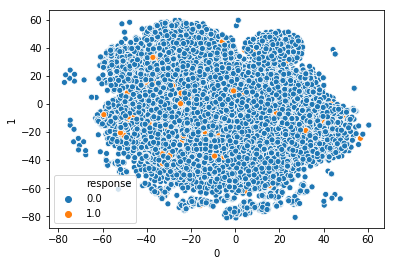

In [69]:
# try tsne
df_tsne = pd.DataFrame(TSNE(n_components=2, perplexity=5).fit_transform(kmeans_train.iloc[:,:-2]))
df_tsne['response'] = kmeans_train.RESPONSE
sns.scatterplot(x=0, y=1, data=df_tsne, hue='response')

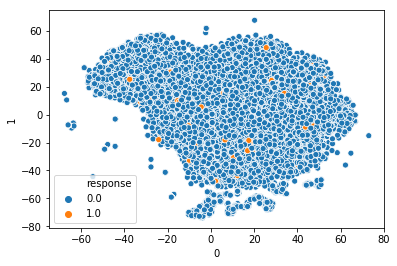

In [70]:
df_tsne = pd.DataFrame(TSNE(n_components=2, perplexity=10).fit_transform(kmeans_train.iloc[:,:-2]))
df_tsne['response'] = kmeans_train.RESPONSE
sns.scatterplot(x=0, y=1, data=df_tsne, hue='response')

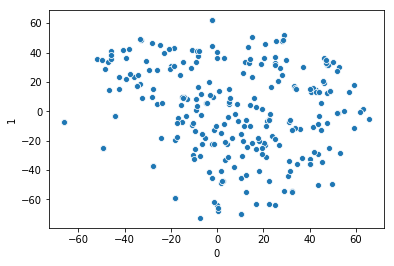

In [71]:
sns.scatterplot(x=0, y=1, data=df_tsne.query('response==1'))

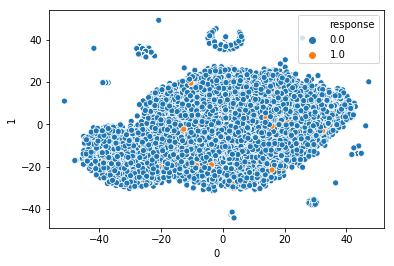

In [72]:
df_tsne = pd.DataFrame(TSNE(n_components=2, perplexity=50).fit_transform(kmeans_train.iloc[:,:-2]))
df_tsne['response'] = kmeans_train.RESPONSE
sns.scatterplot(x=0, y=1, data=df_tsne, hue='response')

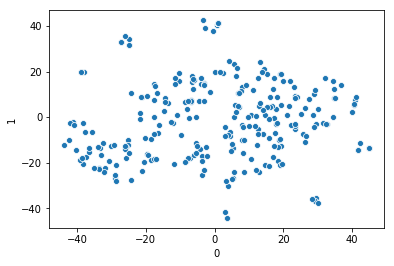

In [73]:
sns.scatterplot(x=0, y=1, data=df_tsne.query('response==1'))

In [ ]:
Xt = df_mailout_train.iloc[:,:-1]
Xt.drop('RESPONSE', axis=1, inplace=True)

dummies = pd.get_dummies(kmeans_train.clusters, prefix='cluster')
Xt = pd.concat([Xt,dummies], axis=1)

yt = kmeans_train.RESPONSE
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)

model3j = XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=34,
              reg_alpha=0, reg_lambda=1, sample_pos_weight=80,
              scale_pos_weight=1, seed=34, silent=None, subsample=0.8,
              verbosity=1)
model3j = skf_noSMOTE(X_traint, y_traint.values, model3j)
pred_model(model3j, X_testt, y_testt)

## DBSCAN

In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(X_pca)

In [ ]:
sns.scatterplot(x=0, y=1, data=kmeans_train, hue='RESPONSE')

In [ ]:
kmeans_train.clusters.unique()

In [ ]:
sns.scatterplot(x=0, y=1, data=kmeans_train, hue='clusters')

In [ ]:
dummies = pd.get_dummies(kmeans_train.clusters, prefix='cluster')
kmeans_train_extended = pd.concat([kmeans_train.iloc[:,:-2],dummies], axis=1)
kmeans_train_extended.head()

In [ ]:
df_mailout_train.isnull().values.any()

In [ ]:
#df_mailout_train_extended = pd.concat([df_mailout_train.iloc[:,:-1],dummies], axis=1)
y2 = df_mailout_train.RESPONSE
X2 = df_mailout_train.iloc[:,:-1]

In [ ]:
y = kmeans_train.RESPONSE
X = kmeans_train_extended

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=34)

In [ ]:
X_train2 = X_train.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)
X_test2 = X_test.reset_index(drop=True)
y_test2 = y_test.reset_index(drop=True)

In [ ]:
y.value_counts()

In [ ]:
def skf_noSMOTE(X, y, model): 

    labels = []
    preds = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X, y):
    
        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        model.fit(X_train_skf, y_train_skf)            
        labels.extend(y_test_skf)
        preds.extend(model.predict(X_test_skf))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    print('auc :', roc_auc_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [ ]:
def pred_model(model, X_test, y_test):
    y_preds = model.predict(X_test)
    print('accuracy :', accuracy_score(y_test, y_preds)) 
    print('F1 :',f1_score(y_test, y_preds))
    print('precision :', precision_score(y_test, y_preds))
    print('recall :', recall_score(y_test, y_preds))
    print('auc :', roc_auc_score(y_test, y_preds))
    y_preds_proba = model.predict_proba(X_test)
    print('auc :', roc_auc_score(y_test, y_preds_proba[:,1]))
    display(confusion_matrix(y_test, y_preds))

In [86]:
Xt = df_mailout_train.iloc[:,:-1]
Xt.drop('RESPONSE', axis=1, inplace=True)
yt = kmeans_train.RESPONSE
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)

model1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=34,
              reg_alpha=0, reg_lambda=1, sample_pos_weight=80,
              scale_pos_weight=1, seed=34, silent=None, subsample=0.8,
              verbosity=1)
model1 = skf_noSMOTE(X_traint, y_traint.values, model1)
pred_model(model1, X_testt, y_testt)

accuracy : 0.9870761534185659
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5


array([[28412,     0],
       [  372,     0]])

accuracy : 0.9887149104246015
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5
auc : 0.7618151662148667


array([[14018,     0],
       [  160,     0]])

### MLP

In [ ]:
Xt = df_mailout_train.iloc[:,:-1]
Xt.drop('RESPONSE', axis=1, inplace=True)
yt = kmeans_train.RESPONSE
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)
input_size = X_traint.shape[1]
num_labels = 2
batch_size = 128
class_weight = {0: 1, 1: 80}

y_train3 = to_categorical(y_traint.values)
y_test3 = to_categorical(y_testt.values)
X_train3 = np.reshape(X_traint.values, [-1, input_size])
X_test3 = np.reshape(X_testt.values, [-1, input_size])

In [ ]:
dropout=0.6
hidden_units = 256
mlp = Sequential()
mlp.add(Dense(hidden_units, input_dim=input_size))
mlp.add(Activation('relu'))
mlp.add(Dropout(dropout))
mlp.add(Dense(hidden_units))
mlp.add(Activation('relu'))
mlp.add(Dropout(dropout))
mlp.add(Dense(num_labels))
# this is the output for one-hot vector
mlp.add(Activation('softmax'))
mlp.summary()

In [ ]:
epochs = 100
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001, momentum=0., decay=0., nesterov=True)
mlp.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
mlp.fit(X_train3, y_train3, epochs=epochs, batch_size=batch_size, class_weight = class_weight, validation_split=0.2)

## Stop here

In [102]:
model1 = AdaBoostClassifier(random_state=34)
model1 = skf_noSMOTE(X_train2, y_train2, model1)

accuracy : 0.9873723413541272
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.49994107074457117


array([[33935,     4],
       [  430,     0]])

In [103]:
model2 = RandomForestClassifier(random_state=34)
model2 = skf_noSMOTE(X_train2, y_train2, model2)

accuracy : 0.9874887253047805
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5


array([[33939,     0],
       [  430,     0]])

In [104]:
#model3 = XGBClassifier(booster='dart', max_depth=5, n_estimators=100, n_jobs=-1, random_state=34)
model3 = XGBClassifier(random_state=34)
model3 = skf_noSMOTE(X_train2, y_train2, model3)

accuracy : 0.9874887253047805
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5


array([[33939,     0],
       [  430,     0]])

In [105]:
def skf_SMOTE(X, y, model):
    
    labels = []
    preds = []

    n = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X, y):

        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        sm = SMOTE(random_state=34)
        X_res, y_res = sm.fit_resample(X_train_skf, y_train_skf)
        
        model.fit(X_res, y_res)
                
        labels.extend(y_res)
        preds.extend(model.predict(X_res))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    print('auc :', roc_auc_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [158]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X2, y2, test_size=0.33, random_state=34)
model12 = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model12 = skf_noSMOTE(X_train4, y_train4, model12)
pred_model(model12, X_test4.values, y_test4)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [106]:
#model = AdaBoostClassifier(random_state=34, n_estimators=1000, learning_rate=0.1)
model4 = AdaBoostClassifier(random_state=34, learning_rate=0.1, n_estimators=100)
model4 = skf_SMOTE(X_train2, y_train2, model4)

accuracy : 0.7754648045021951
F1 : 0.7782917657669453
precision : 0.7686146906290853
recall : 0.7882156221456141
auc : 0.7754648045021951


array([[103543,  32213],
       [ 28751, 107005]])

In [107]:
model5 = RandomForestClassifier(random_state=34)
model5 = skf_SMOTE(X_train2, y_train2, model5)

accuracy : 0.9493061080173252
F1 : 0.9493553514659131
precision : 0.9484340538156153
recall : 0.9502784407319014
auc : 0.9493061080173253


array([[128742,   7014],
       [  6750, 129006]])

In [108]:
model6 = XGBClassifier(random_state=34)
model6 = skf_SMOTE(X_train2, y_train2, model6)

accuracy : 0.8891688028521759
F1 : 0.8920768358988337
precision : 0.8692686199955267
recall : 0.9161142048970211
auc : 0.8891688028521759


array([[117052,  18704],
       [ 11388, 124368]])

In [109]:
model7 = RandomForestClassifier(random_state=34, n_estimators = 100)
model7 = skf_SMOTE(X_train2, y_train2, model7)

accuracy : 0.9493539880373612
F1 : 0.9494037434827562
precision : 0.9484719495967594
recall : 0.9503373699873302
auc : 0.9493539880373612


array([[128747,   7009],
       [  6742, 129014]])

In [110]:
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
model8 = XGBClassifier(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=200, n_jobs=-1, random_state=34)
model8 = skf_SMOTE(X_train2, y_train2, model8)

accuracy : 0.947435104157459
F1 : 0.9477682950037329
precision : 0.9417985569649715
recall : 0.9538141960576328
auc : 0.9474351041574588


array([[127754,   8002],
       [  6270, 129486]])

In [111]:
def pred_model(model, X_test, y_test):
    y_preds = model.predict(X_test)
    print('accuracy :', accuracy_score(y_test, y_preds)) 
    print('F1 :',f1_score(y_test, y_preds))
    print('precision :', precision_score(y_test, y_preds))
    print('recall :', recall_score(y_test, y_preds))
    print('auc :', roc_auc_score(y_test, y_preds))
    y_preds_proba = model.predict_proba(X_test)
    print('auc :', roc_auc_score(y_test, y_preds_proba[:,1]))
    display(confusion_matrix(y_test, y_preds))

In [112]:
y_test.value_counts()

0    8491
1     102
Name: RESPONSE, dtype: int64

In [113]:
pred_model(model1, X_test2, y_test2)

accuracy : 0.9880134993599441
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.4999411141208338
auc : 0.5383196972111186


array([[8490,    1],
       [ 102,    0]])

In [114]:
pred_model(model2, X_test2, y_test2)

accuracy : 0.9881298731525661
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5
auc : 0.47400072972305163


array([[8491,    0],
       [ 102,    0]])

In [115]:
pred_model(model3, X_test2, y_test2)

accuracy : 0.9881298731525661
F1 : 0.0
precision : 0.0
recall : 0.0
auc : 0.5
auc : 0.5404159190469262


array([[8491,    0],
       [ 102,    0]])

In [116]:
pred_model(model4, X_test2, y_test2)

accuracy : 0.7298964273245665
F1 : 0.023559108119478336
precision : 0.012307692307692308
recall : 0.27450980392156865
auc : 0.5049383314743869
auc : 0.5411381370355232


array([[6244, 2247],
       [  74,   28]])

In [117]:
pred_model(model5, X_test2, y_test2)

accuracy : 0.8910741301059002
F1 : 0.018867924528301886
precision : 0.01056338028169014
recall : 0.08823529411764706
auc : 0.49447685092173715
auc : 0.5246541320567798


array([[7648,  843],
       [  93,    9]])

In [118]:
pred_model(model6, X_test2.values, y_test2)

accuracy : 0.803677411846852
F1 : 0.01861547411285631
precision : 0.009894867037724181
recall : 0.1568627450980392
auc : 0.48415508000397184
auc : 0.536569285587277


array([[6890, 1601],
       [  86,   16]])

In [119]:
pred_model(model7, X_test2, y_test2)

accuracy : 0.892470615617363
F1 : 0.01910828025477707
precision : 0.010714285714285714
recall : 0.08823529411764706
auc : 0.49518348147173125
auc : 0.5424515230659452


array([[7660,  831],
       [  93,    9]])

In [120]:
pred_model(model8, X_test2.values, y_test2)

accuracy : 0.8871174211567555
F1 : 0.018218623481781375
precision : 0.010158013544018058
recall : 0.08823529411764706
auc : 0.49247473103008715
auc : 0.5442717895072291


array([[7614,  877],
       [  93,    9]])

In [121]:
model9 = AdaBoostClassifier(random_state=34, learning_rate=0.05, n_estimators=100)
model9 = skf_SMOTE(X_train2, y_train2, model9)
pred_model(model9, X_test2, y_test2)

accuracy : 0.7422655352249624
F1 : 0.7483548018210457
precision : 0.7310821634838329
recall : 0.7664633607354371
auc : 0.7422655352249623


array([[ 97482,  38274],
       [ 31704, 104052]])

accuracy : 0.6951006633306179
F1 : 0.02674591381872214
precision : 0.013899613899613899
recall : 0.35294117647058826
auc : 0.5260760528448808
auc : 0.5544411499142115


array([[5937, 2554],
       [  66,   36]])

In [122]:
model10 = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=200, n_jobs=-1, random_state=34)
model10 = skf_SMOTE(X_train2, y_train2, model10)
pred_model(model10, X_test2.values, y_test2)

accuracy : 0.8733683962403135
F1 : 0.8772816504265267
precision : 0.8509839766227651
recall : 0.9052564895842541
auc : 0.8733683962403134


array([[114236,  21520],
       [ 12862, 122894]])

accuracy : 0.7982078435936227
F1 : 0.01923076923076923
precision : 0.01020408163265306
recall : 0.16666666666666666
auc : 0.48623051858830924
auc : 0.5138087386644683


array([[6842, 1649],
       [  85,   17]])

In [123]:
model11 = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11 = skf_SMOTE(X_train2, y_train2, model11)
pred_model(model11, X_test2.values, y_test2)

accuracy : 0.8750883938831433
F1 : 0.8773262438283328
precision : 0.86188516726009
recall : 0.893330681516839
auc : 0.8750883938831433


array([[116322,  19434],
       [ 14481, 121275]])

accuracy : 0.8105434656115443
F1 : 0.019277108433734938
precision : 0.010269576379974325
recall : 0.1568627450980392
auc : 0.4876293468747762
auc : 0.5239174812546619


array([[6949, 1542],
       [  86,   16]])

In [124]:
model11b = AdaBoostClassifier(random_state=34, learning_rate=1., n_estimators=200)
model11b = skf_SMOTE(X_train2b, y_train2b, model11b)
pred_model(model11b, X_test2.values, y_test2)

NameError: name 'X_train2b' is not defined

In [125]:
model12 = XGBClassifier(learning_rate=0.01, n_estimators=1000, n_jobs=-1, random_state=34)
model12 = skf_SMOTE(X_train2, y_train2, model12)
pred_model(model12, X_test2.values, y_test2)

accuracy : 0.8919568932496538
F1 : 0.8950405919374287
precision : 0.8702037806210126
recall : 0.9213368101594036
auc : 0.8919568932496538


array([[117100,  18656],
       [ 10679, 125077]])

accuracy : 0.8034446642616083
F1 : 0.018593840790238233
precision : 0.009882643607164917
recall : 0.1568627450980392
auc : 0.48403730824563956
auc : 0.5260137030904695


array([[6888, 1603],
       [  86,   16]])

### MLP

In [116]:
Xt = df_mailout_train.iloc[:,:-1]
Xt.drop('RESPONSE', axis=1, inplace=True)
yt = kmeans_train.RESPONSE
X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.33, shuffle=True, random_state=34)

In [128]:
input_size = X_traint.shape[1]
num_labels = 2
batch_size = 128
class_weight = {0: 1, 1: 80}
#sm = SMOTE(random_state=34)
#X_res, y_res = sm.fit_resample(X_traint, y_traint)
y_train3 = to_categorical(y_traint.values)
y_test3 = to_categorical(y_testt.values)
X_train3 = np.reshape(X_traint.values, [-1, input_size])
X_test3 = np.reshape(X_testt.values, [-1, input_size])

In [124]:
dropout=0.6
hidden_units = 256
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
# this is the output for one-hot vector
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               126976    
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
__________

In [133]:
epochs = 100
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001, momentum=0., decay=0., nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train3, y_train3, epochs=epochs, batch_size=batch_size, class_weight = class_weight, validation_split=0.2)

Train on 23027 samples, validate on 5757 samples
Epoch 1/100
23027/23027 [==============================] - 2s 93us/step - loss: 0.6681 - acc: 0.9640 - val_loss: 0.3921 - val_acc: 0.9958
Epoch 2/100
23027/23027 [==============================] - 2s 71us/step - loss: 0.4764 - acc: 0.9516 - val_loss: 0.4855 - val_acc: 0.9958
Epoch 3/100
23027/23027 [==============================] - 2s 71us/step - loss: 0.5432 - acc: 0.9357 - val_loss: 0.5044 - val_acc: 0.9922
Epoch 4/100
23027/23027 [==============================] - 2s 70us/step - loss: 0.5353 - acc: 0.9368 - val_loss: 0.5811 - val_acc: 0.9762
Epoch 5/100
23027/23027 [==============================] - 2s 72us/step - loss: 0.4205 - acc: 0.8958 - val_loss: 0.7419 - val_acc: 0.8668
Epoch 6/100
23027/23027 [==============================] - 2s 72us/step - loss: 0.5294 - acc: 0.8408 - val_loss: 0.6166 - val_acc: 0.9062
Epoch 7/100
23027/23027 [==============================] - 2s 73us/step - loss: 0.4376 - acc: 0.8750 - val_loss: 1.0332 - v

23027/23027 [==============================] - 2s 93us/step - loss: 0.3954 - acc: 0.8961 - val_loss: 1.9452 - val_acc: 0.8605
Epoch 60/100
23027/23027 [==============================] - 2s 102us/step - loss: 0.3684 - acc: 0.8962 - val_loss: 2.7012 - val_acc: 0.8668
Epoch 61/100
23027/23027 [==============================] - 2s 93us/step - loss: 0.3802 - acc: 0.8837 - val_loss: 2.4312 - val_acc: 0.9901
Epoch 62/100
23027/23027 [==============================] - 2s 94us/step - loss: 0.3705 - acc: 0.9153 - val_loss: 2.7798 - val_acc: 0.9873
Epoch 63/100
23027/23027 [==============================] - 2s 95us/step - loss: 0.3798 - acc: 0.9218 - val_loss: 2.8263 - val_acc: 0.8555
Epoch 64/100
23027/23027 [==============================] - 2s 87us/step - loss: 0.3899 - acc: 0.8958 - val_loss: 3.0617 - val_acc: 0.8588
Epoch 65/100
23027/23027 [==============================] - 2s 72us/step - loss: 0.3713 - acc: 0.9087 - val_loss: 3.3887 - val_acc: 0.8567
Epoch 66/100
23027/23027 [=============

In [131]:
def predict_nn(X, y, model):
    
    y_preds = model.predict(X)

    df_pred = pd.DataFrame(y[:,0].astype('int64'), columns=['true'])
    df_pred['true'] = df_pred['true'].apply(lambda x: 0 if x==1 else 1)
    df_pred['preds'] = np.array(y_preds[:,0])
    df_pred['preds'] = df_pred['preds'].apply(lambda x: 1 if x < 0.5 else 0)
    df_pred['preds_proba'] = np.array(y_preds[:,0])

    class0 = df_pred[(df_pred['true']==1) & (df_pred['preds']==1)].shape[0]
    #print(class0)
    all_entries = df_pred.shape[0]
    print(accuracy_score(df_pred['true'], df_pred['preds']))
    print(roc_auc_score(df_pred['true'], df_pred['preds']))
    print(roc_auc_score(df_pred['true'], df_pred['preds_proba']))

In [134]:
predict_nn(X_test3, y_test3, model)

0.9796868387642826
0.504702436153517
0.42516385183335714


In [ ]:
### Using full df

In [ ]:
X2 = df_mailout_train.iloc[:,:-1]
y2 = df_mailout_train.RESPONSE
X_train4, X_test4, y_train4, y_test4 = train_test_split(X2, y2, test_size=0.2, shuffle=True, random_state=34)

In [ ]:
model12 = XGBClassifier(learning_rate=0.01, n_estimators=1000, n_jobs=-1, random_state=34)
model12 = skf_SMOTE(X_train4, y_train4, model12)
pred_model(model12, X_test4.values, y_test4)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv')

In [ ]:
#, kmeans_pipe = pipeline(customers)

## Code Bank

In [ ]:
#customer = (customer.pipe(pre_clean)
#      .pipe(missing_values)
#      .pipe(drop_features, arg1=445E3)
#      .pipe(drop_rows).pipe(impute_calc)
#      .pipe(pragende_jugendjahre)
#      .pipe(cameo_intl_2015)
#      .pipe(lp_lebensphase_fein)
#      .pipe(lp_lebensphase_grob)
#      .pipe(adjust_types))
#
#def dummies_scale(df):
#    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
#                         columns=onehot.get_feature_names())
#    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
#    df[list_scale] = scaler.transform(df[list_scale])
#    return df
#
#dummies_scale(customer)